# <center>**Code for construction of Logistic Regression binary & multiclass classifiers**<center>

# Import Statements

In [ ]:
import time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import label_binarize

# Helper Functions

## Fetching inputs

In [ ]:
# Function to fetch the gene presence/absence dataframe and append the binary labels

def fetch_all_dataframe_and_labels():
    df_all = pd.read_csv('gene_presence_absence.Rtab', sep='\t', index_col=0)
    df_all=df_all.tranpose()
    
    labels_all = pd.read_csv('biofilm_pheno_binary.tsv', sep='\t', index_col=0)

    exc_all=[idx for idx in df_all.index if idx not in labels_all.index]
    df_all=df_all.drop(index=exc_all)

    df_all['Label']=labels_all
    labels_all=df_all.loc[:,'Label']

    return df_all,labels_all

In [ ]:
# Function to fetch the gene presence/absence dataframe and append the multiclass labels

def fetch_all_df_and_multilabels():
    df_all = pd.read_csv('gene_presence_absence.Rtab', sep='\t', index_col=0)
    df_all=df_all.tranpose()
    
    labels_all = pd.read_csv('biofilm_pheno_multi.tsv', sep='\t', index_col=0)

    exc_all=[idx for idx in df_all.index if idx not in labels_all.index]
    df_all=df_all.drop(index=exc_all)

    df_all['Label']=labels_all
    labels_all=df_all.loc[:,'Label']

    return df_all,labels_all

## Processing

In [ ]:
# Function to remove all hypothetical genes having prefix "group_"

def remove_group_genes(df):
    grp=[]
    for gene in df.columns:
        if gene.startswith('group_'):
            grp.append(gene)

    df=df.drop(columns=grp)

    return df

In [ ]:
# Function to perform SMOTE oversampling

def SMOTE_oversampling(df,labels):
    smote = SMOTE(random_state=0)
    df_res, labels_res = smote.fit_resample(df,labels)

    return df_res, labels_res

In [ ]:
# Function to prepare the training and testing dataframes & their corresponding labels

def traintest_split(df, labels, train=0.7, test=0.3):
    if 'Label' not in df.columns:
        df=pd.concat([df,labels],axis=1)

    train_df, test_df = train_test_split(df, train_size=train, test_size=test, random_state=0, stratify=df.loc[:,'Label'])
    train_labels = train_df.loc[:,'Label']
    test_labels = test_df.loc[:,'Label']

    train_df = train_df.drop(labels='Label', axis=1)
    test_df = test_df.drop(labels='Label', axis=1)

    return train_df,test_df,train_labels,test_labels

In [ ]:
# Function to perform feature selection using Recursive Feature Elimination with Cross Validation

def feature_selection_RFE(estimator,train_df, train_labels, step_size=1, scoring_metric='accuracy', threads=36):
    if 'Label' in train_df.columns:
        train_df=train_df.drop(columns=['Label'])

    start_time = time.time()

    selector = RFECV(estimator, step=step_size, cv=5, scoring=scoring_metric, n_jobs=threads)

    feature_subset = selector.fit(train_df, train_labels)

    end_time = time.time()
    elapsed_time_minutes = (end_time - start_time) / 60

    print(f'Time taken to perform RFE = {elapsed_time_minutes} minutes')

    return feature_subset, selector.n_features_

In [ ]:
# Function to drop the features that were not chosen by RFECV from the training and testing dataframes

def retain_selected_features(train_df,test_df,RFE_output):
    bool_feature_subset=RFE_output.get_support()
    features_to_drop_indices=[idx for idx in range(len(bool_feature_subset)) if bool_feature_subset[idx] == False]
    features_to_drop=[train_df.columns[feature_idx] for feature_idx in features_to_drop_indices]
    features_to_keep_indices=[idx for idx in range(len(bool_feature_subset)) if bool_feature_subset[idx] == True]
    features_to_keep=[train_df.columns[feature_idx] for feature_idx in features_to_keep_indices]

    train_df = train_df.drop(columns=features_to_drop)
    test_df = test_df.drop(columns=features_to_drop)

    return train_df, test_df, features_to_keep

In [ ]:
# Function to determine baseline classification scores before hyperparameter tuning

def baseline_scores(estimator,train_df,train_labels):
    warnings.filterwarnings('ignore')

    baseline_accuracy = cross_val_score(estimator, train_df, train_labels, cv=5, scoring='accuracy')
    baseline_f1 = cross_val_score(estimator, train_df, train_labels, cv=5, scoring='f1_weighted')
    baseline_rocauc = cross_val_score(estimator, train_df, train_labels, cv=5, scoring='roc_auc')

    return baseline_accuracy.mean(), baseline_f1.mean(), baseline_rocauc.mean()

In [ ]:
# Function to perform hyperparameter tuning using GridSearchCV

def hyperparameter_tuning(estimator, param_grid, train_df,train_labels):
    grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='accuracy', n_jobs=36)
    grid_search.fit(train_df, train_labels)

    grid_results_df=pd.DataFrame(grid_search.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
    best_params_grid = grid_search.best_params_
    best_model_grid = grid_search.best_estimator_

    return best_params_grid, best_model_grid

In [ ]:
# Function to determine classification scores after hyperparameter tuning

def tuned_scores(best_model_grid, train_df, train_labels):
    warnings.filterwarnings('ignore')

    cv_accuracy_tuned = cross_val_score(best_model_grid, train_df, train_labels, cv=5, scoring='accuracy')
    cv_f1_tuned = cross_val_score(best_model_grid, train_df, train_labels, cv=5, scoring='f1_weighted')
    cv_roc_auc_tuned = cross_val_score(best_model_grid, train_df, train_labels, cv=5, scoring='roc_auc')

    return cv_accuracy_tuned, cv_f1_tuned, cv_roc_auc_tuned

In [ ]:
# Function to test the model on the testing data

def testing(model, test_df, test_labels):
    model_predictions = model.predict(test_df)

    print(classification_report(test_labels, model_predictions))

    disp = ConfusionMatrixDisplay.from_predictions(test_labels, model_predictions, labels=model.classes_, cmap='Blues')

In [ ]:
# Function to evaluate binary classifier performance using various metrics (accuracy, precision, recall, f1, roc_auc)

def binary_classifier_scores(best_model, test_df, test_labels):
    y_pred=best_model.predict(test_df)
    y_prob=best_model.predict_proba(test_df)[:, 1]

    accuracy = accuracy_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    recall = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)
    roc_auc = roc_auc_score(test_labels, y_prob)

    return(accuracy,precision,recall,f1,roc_auc)

In [ ]:
# Function to plot the ROC curve for the binary classifier

def plot_binary_roc_curve(best_model, test_df, test_labels):
    y_pred=best_model.predict(test_df)
    y_prob=best_model.predict_proba(test_df)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_labels, y_prob)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [ ]:
# Function to evaluate multiclass classifier performance using various metrics (accuracy, precision, recall, f1, roc_auc)

def multiclass_classifier_scores(best_model, test_df, test_labels):
    y_pred = best_model.predict(test_df)
    y_prob = best_model.predict_proba(test_df)

    accuracy = accuracy_score(test_labels, y_pred)

    # Precision, Recall, F1 - using 'macro' average for multi-class
    precision = precision_score(test_labels, y_pred, average='macro')
    recall = recall_score(test_labels, y_pred, average='macro')
    f1 = f1_score(test_labels, y_pred, average='macro')

    y_test_bin = label_binarize(test_labels, classes=[0, 1, 2, 3])
    roc_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')

    return accuracy, precision, recall, f1, roc_auc

In [ ]:
# Function to plot the ROC curve for the multiclass classifier

def plot_multiclass_roc_curve(best_model, test_df, test_labels):
    y_pred = best_model.predict(test_df)
    y_prob = best_model.predict_proba(test_df)

    y_test_bin = label_binarize(test_labels, classes=[0, 1, 2, 3])

    n_classes = y_test_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


# Main Code

## Binary classifier

In [ ]:
# Fetching the gene presence/absence dataframe with binary labels

df_all,labels_all=fetch_all_dataframe_and_labels()

print(df_all.head())
print(df_all.shape)
print(labels_all.shape)

       rpmJ  rpsJ  rplB  rpmE2  rpsG  rplO  rpsF  rplP  rplN  atpE  ...  \
AA1       1     1     1      1     1     1     1     1     1     1  ...   
AA100     1     1     1      1     1     1     1     1     1     1  ...   
AA102     1     1     1      1     1     1     1     1     1     1  ...   
AA103     1     1     1      1     1     1     1     1     1     1  ...   
AA11      1     1     1      1     1     1     1     1     1     1  ...   

       group_9986  group_9987  group_9990  group_9992  group_9994  group_9996  \
AA1             0           0           0           0           0           0   
AA100           0           0           0           0           0           0   
AA102           0           0           0           0           0           0   
AA103           0           0           0           0           0           0   
AA11            0           0           0           0           0           0   

       group_9997  ydjI  group_9999  Label  
AA1             0

In [ ]:
# Removing all hypothetical genes having prefix "group_"

df_all=remove_group_genes(df_all)
print(df_all.head())
print(df_all.shape)

       rpmJ  rpsJ  rplB  rpmE2  rpsG  rplO  rpsF  rplP  rplN  atpE  ...  \
AA1       1     1     1      1     1     1     1     1     1     1  ...   
AA100     1     1     1      1     1     1     1     1     1     1  ...   
AA102     1     1     1      1     1     1     1     1     1     1  ...   
AA103     1     1     1      1     1     1     1     1     1     1  ...   
AA11      1     1     1      1     1     1     1     1     1     1  ...   

       splD_1  cysC  eutB  lepB  flgE  purA_2  greA_2  pdp_2  ydjI  Label  
AA1         0     0     0     0     0       0       0      0     0      1  
AA100       0     0     0     0     0       0       0      0     0      1  
AA102       0     0     0     0     0       0       0      0     0      1  
AA103       0     0     0     0     0       0       0      0     0      1  
AA11        0     0     0     0     0       0       0      0     0      0  

[5 rows x 2570 columns]
(178, 2570)


In [ ]:
# Performing SMOTE oversampling of the minor class to the majority class

df_all_res,labels_all_res=SMOTE_oversampling(df_all,labels_all)

class_counts_resampled = pd.Series(labels_all_res).value_counts()
print(f"Class Distribution After RandomOverSampler:\n{class_counts_resampled}")

Class Distribution After RandomOverSampler:
Label
1    127
0    127
Name: count, dtype: int64


In [ ]:
# Preparing the training and testing dataframes

train_df,test_df,train_labels,test_labels=traintest_split(df_all_res,labels_all_res)
print('Number of samples within each class:\t\t\t\t\t ' , np.unique(labels_all_res, return_counts=True))
print('Number of samples within each class in training dataframe (stratified):\t ' , np.unique(train_labels, return_counts=True))
print('Number of samples within each class in testing dataframe (stratified):\t ', np.unique(test_labels, return_counts=True))

Number of samples within each class:					  (array([0, 1], dtype=int64), array([127, 127], dtype=int64))
Number of samples within each class in training dataframe (stratified):	  (array([0, 1], dtype=int64), array([88, 89], dtype=int64))
Number of samples within each class in testing dataframe (stratified):	  (array([0, 1], dtype=int64), array([39, 38], dtype=int64))


In [ ]:
# Performing feature selection using Recursive Feature Elimination with Cross Validation

estimator = LogisticRegression(random_state=0,solver='liblinear')
selected_features,num_features=feature_selection_RFE(estimator,train_df,train_labels)
print('Number of features selected =',num_features)

Time taken to perform RFE = 2.0736364761988324 minutes
Number of features selected = 157


In [ ]:
# Retaining the selected features in the training and testing dataframes

train_df,test_df,features_to_keep = retain_selected_features(train_df,test_df,selected_features)

print(train_df.shape)
print(test_df.shape)
print(features_to_keep)

(177, 157)
(77, 157)
['flp', 'acsA_2', 'trpC', 'dtpT', 'garK_2', 'arcR', 'mrpB', 'isdA', 'agrA', 'graR_1', 'ydjZ', 'prkC', 'tcyP', 'ugpQ', 'trmB', 'pfbA', 'coaD', 'adh', 'pepA_1', 'spsB_1', 'yfbR', 'orr', 'nudF', 'yfcJ', 'plsY', 'ymcA', 'mnaA_1', 'fnbB', 'ssl3', 'clpB', 'sdhC', 'oppF_1', 'murB', 'comEA', 'bacC', 'lysP_2', 'clfB', 'dapE', 'ypjD', 'pitA', 'splB', 'menH_2', 'treP_2', 'nixA', 'nikD', 'murJ', 'rpsN2', 'entS', 'tagX', 'ppaC', 'rpsT', 'tetA', 'hdfR_2', 'apt', 'nusB', 'azoR', 'lipA_1', 'dgk', 'addB', 'purC', 'cynR', 'kdpA', 'ftsK', 'gabR', 'mutY', 'hld', 'hlb_2', 'queE_1', 'odhA', 'opuD_3', 'spo0J', 'mscS', 'plc', 'grsB', 'sdrM', 'sarX', 'kimA', 'tkt', 'gph', 'thyA', 'tcaA', 'dnaE', 'isdB', 'trmK', 'sdrE', 'potB', 'malP', 'yfkN', 'nikA', 'putP', 'coiA', 'sarU', 'rnhA', 'lolD_1', 'mutS_2', 'tal', 'bcrR', 'pre_1', 'pre_2', 'cadC', 'bcrA_1', 'aphA', 'hlgC_2', 'epiD', 'essG_1', 'splC', 'ggt', 'tet(K)', 'arsC', 'ssl1', 'ecfT', 'norB_4', 'splF', 'satA', 'nisC', 'agrB', 'emp', 'essG_

In [ ]:
# Determining baseline classification scores before hyperparameter tuning

estimator = LogisticRegression(random_state=0)

baseline_accuracy,baseline_f1,baseline_roc_auc=baseline_scores(estimator,train_df,train_labels)
print(f'Baseline ACCURACY = {baseline_accuracy}')
print(f'Baseline F1 SCORE = {baseline_f1}')
print(f'Baseline ROC AUC = {baseline_roc_auc}')

Baseline ACCURACY = 0.9774603174603174
Baseline F1 SCORE = 0.9774423774423774
Baseline ROC AUC = 0.9986928104575163


In [ ]:
# Performing hyperparameter tuning using GridSearchCV

param_grid = {
    'C': [0.01,0.1,1,10,100],
    'solver': ['newton-cg','liblinear','lbfgs', 'newton-cholesky', 'sag', 'saga'],
    'penalty':['l1', 'l2', 'elasticnet', None],
    'dual':[True,False]}

warnings.filterwarnings('ignore')

estimator = LogisticRegression(random_state=0)
best_params,best_model=hyperparameter_tuning(estimator,param_grid,train_df,train_labels)

print('Best parameters chosen by grid search: ', best_params)

accuracies,f1_scores,roc_aucs = tuned_scores(best_model,train_df,train_labels)
print(f'\nHaving an average ACCURACY {accuracies.mean()}\n\t\t  F1 SCORE {f1_scores.mean()}\n\t\t  ROC AUC  {roc_aucs.mean()}')

Best parameters chosen by grid search:  {'C': 0.01, 'dual': False, 'penalty': None, 'solver': 'sag'}

Having an average ACCURACY 0.9774603174603174
		  F1 SCORE 0.9774423774423774
		  ROC AUC  0.9986928104575163


              precision    recall  f1-score   support

           0       0.79      0.79      0.79        39
           1       0.79      0.79      0.79        38

    accuracy                           0.79        77
   macro avg       0.79      0.79      0.79        77
weighted avg       0.79      0.79      0.79        77



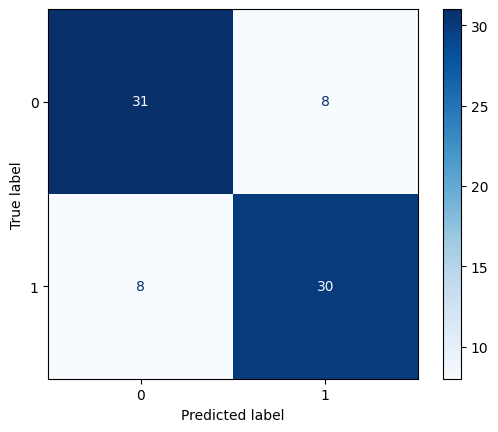

In [ ]:
# Testing the tuned binary classifier on testing data

testing(best_model,test_df,test_labels)

Accuracy:       0.7922077922077922
Precision:      0.7894736842105263
Recall:         0.7894736842105263
F1 Score:       0.7894736842105263
ROC-AUC Score:  0.8994601889338731



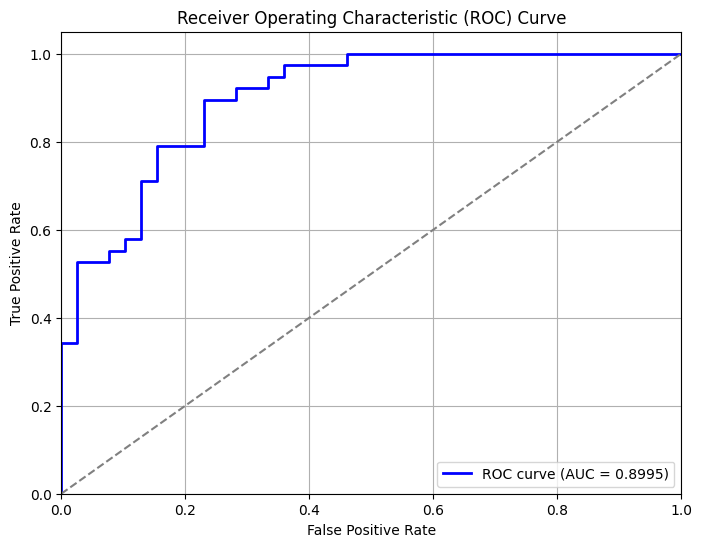

In [ ]:
# Evaluating the binary classifier performance using various metrics & plotting the ROC curve

accuracy,precision,recall,f1,roc_auc=binary_classifier_scores(best_model,test_df,test_labels)

print(f'Accuracy:       {accuracy}')
print(f'Precision:      {precision}')
print(f'Recall:         {recall}')
print(f'F1 Score:       {f1}')
print(f'ROC-AUC Score:  {roc_auc}\n')

plot_binary_roc_curve(best_model,test_df,test_labels)

## Multi-class classifier

In [ ]:
# Fetching the gene presence/absence dataframe with multiclass labels

df_all,labels_all=fetch_all_df_and_multilabels()

print(df_all.head())
print(df_all.shape)
print(labels_all.shape)

       rpmJ  rpsJ  rplB  rpmE2  rpsG  rplO  rpsF  rplP  rplN  atpE  ...  \
AA1       1     1     1      1     1     1     1     1     1     1  ...   
AA100     1     1     1      1     1     1     1     1     1     1  ...   
AA102     1     1     1      1     1     1     1     1     1     1  ...   
AA103     1     1     1      1     1     1     1     1     1     1  ...   
AA11      1     1     1      1     1     1     1     1     1     1  ...   

       group_9986  group_9987  group_9990  group_9992  group_9994  group_9996  \
AA1             0           0           0           0           0           0   
AA100           0           0           0           0           0           0   
AA102           0           0           0           0           0           0   
AA103           0           0           0           0           0           0   
AA11            0           0           0           0           0           0   

       group_9997  ydjI  group_9999  Label  
AA1             0

In [ ]:
# Removing all hypothetical genes having prefix "group_"

df_all=remove_group_genes(df_all)
print(df_all.head())
print(df_all.shape)

       rpmJ  rpsJ  rplB  rpmE2  rpsG  rplO  rpsF  rplP  rplN  atpE  ...  \
AA1       1     1     1      1     1     1     1     1     1     1  ...   
AA100     1     1     1      1     1     1     1     1     1     1  ...   
AA102     1     1     1      1     1     1     1     1     1     1  ...   
AA103     1     1     1      1     1     1     1     1     1     1  ...   
AA11      1     1     1      1     1     1     1     1     1     1  ...   

       splD_1  cysC  eutB  lepB  flgE  purA_2  greA_2  pdp_2  ydjI  Label  
AA1         0     0     0     0     0       0       0      0     0      3  
AA100       0     0     0     0     0       0       0      0     0      3  
AA102       0     0     0     0     0       0       0      0     0      3  
AA103       0     0     0     0     0       0       0      0     0      2  
AA11        0     0     0     0     0       0       0      0     0      1  

[5 rows x 2570 columns]
(178, 2570)


In [ ]:
# Performing SMOTE oversampling of the minor classes to the majority class

df_all_res,labels_all_res=SMOTE_oversampling(df_all,labels_all)

class_counts_resampled = pd.Series(labels_all_res).value_counts()
print(f"Class Distribution After RandomOverSampler:\n{class_counts_resampled}")

Class Distribution After RandomOverSampler:
Label
3    74
2    74
1    74
0    74
Name: count, dtype: int64


In [ ]:
# Preparing the training and testing dataframes

train_df,test_df,train_labels,test_labels=traintest_split(df_all_res,labels_all_res)
print('Number of samples within each class:\t\t\t\t\t ' , np.unique(labels_all_res, return_counts=True))
print('Number of samples within each class in training dataframe (stratified):\t ' , np.unique(train_labels, return_counts=True))
print('Number of samples within each class in testing dataframe (stratified):\t ', np.unique(test_labels, return_counts=True))

Number of samples within each class:					  (array([0, 1, 2, 3], dtype=int64), array([74, 74, 74, 74], dtype=int64))
Number of samples within each class in training dataframe (stratified):	  (array([0, 1, 2, 3], dtype=int64), array([51, 52, 52, 52], dtype=int64))
Number of samples within each class in testing dataframe (stratified):	  (array([0, 1, 2, 3], dtype=int64), array([23, 22, 22, 22], dtype=int64))


In [ ]:
# Performing feature selection using Recursive Feature Elimination with Cross Validation

estimator = LogisticRegression(random_state=0,solver='liblinear')
selected_features,num_features=feature_selection_RFE(estimator,train_df,train_labels)
print('Number of features selected =',num_features)

Time taken to perform RFE = 6.263292777538299 minutes
Number of features selected = 435


In [ ]:
# Retaining the selected features in the training and testing dataframes

train_df,test_df,features_to_keep = retain_selected_features(train_df,test_df,selected_features)

print(train_df.shape)
print(test_df.shape)
print(features_to_keep)

(207, 435)
(89, 435)
['pyrF', 'cdaA', 'rocD2_1', 'sglT', 'pbuG', 'fhs', 'acsA_2', 'scpB', 'crtM', 'narX', 'lepA', 'ptsI', 'msrA1', 'cidB', 'rlmH', 'nrtD', 'dtpT', 'msrA2', 'lip2_2', 'yciC_1', 'bioK', 'secE', 'acnA', 'pyrC', 'tarB', 'metP_2', 'rpmF', 'clpL', 'gcvPB', 'glpQ_1', 'thiK', 'glnR', 'codY', 'garK_2', 'hchA', 'dtd', 'purH', 'mcsB', 'mrpB', 'ydbM', 'iolS', 'rimM', 'srrA', 'mecA_2', 'ribE', 'arcB', 'lysC', 'gcvT', 'rsuA', 'isdA', 'agrA', 'purQ', 'ydjZ', 'scmP_3', 'rsbW', 'groS', 'zapA', 'iscS_2', 'pepF1_1', 'nrgA', 'glcK', 'ytpA', 'tcyP', 'phnE_1', 'pitA_3', 'rplGA', 'yhaN', 'rluB', 'lipM', 'nreB', 'ugpQ', 'fdhD', 'tagU_2', 'tycC', 'trmB', 'dltA', 'alsS', 'rnmV_2', 'oppC', 'pfbA', 'yfiZ_2', 'adh', 'ligA', 'yqgN', 'map_1', 'spsB_1', 'dnaG', 'hemW', 'bioY', 'sirB', 'orr', 'tig', 'yoeB', 'mecA_1', 'mrcA', 'ftsY', 'yfcJ', 'mprF', 'ymcA', 'mnaA_1', 'recU', 'clpB', 'sdhC', 'rbfA', 'efeU', 'potD', 'priA', 'nrdE', 'yitU', 'crtN', 'pycA', 'azo1', 'oppF_1', 'ecfT_2', 'proS', 'crcB_1', 'fep

In [ ]:
# Determining baseline classification scores before hyperparameter tuning

estimator = LogisticRegression(random_state=0)

baseline_accuracy,baseline_f1,baseline_roc_auc=baseline_scores(estimator,train_df,train_labels)
print(f'Baseline ACCURACY = {baseline_accuracy}')
print(f'Baseline F1 SCORE = {baseline_f1}')
print(f'Baseline ROC AUC = {baseline_roc_auc}')

Baseline ACCURACY = 0.8166085946573751
Baseline F1 SCORE = 0.8185542717078093
Baseline ROC AUC = nan


In [ ]:
# Performing hyperparameter tuning using GridSearchCV

param_grid = {
    'C': [0.01,0.1,1,10,100],
    'solver': ['newton-cg','liblinear','lbfgs', 'newton-cholesky', 'sag', 'saga'],
    'penalty':['l1', 'l2', 'elasticnet', None],
    'dual':[True,False]}

warnings.filterwarnings('ignore')

estimator = LogisticRegression(random_state=0)
best_params,best_model=hyperparameter_tuning(estimator,param_grid,train_df,train_labels)

print('Best parameters chosen by grid search: ', best_params)
accuracies,f1_scores,roc_aucs = tuned_scores(best_model,train_df,train_labels)
print(f'\nHaving an average ACCURACY {accuracies.mean()}\n\t\t  F1 SCORE {f1_scores.mean()}\n\t\t  ROC AUC  {roc_aucs.mean()}')

Best parameters chosen by grid search:  {'C': 100, 'dual': False, 'penalty': 'l2', 'solver': 'lbfgs'}

Having an average ACCURACY 0.8551684088269453
		  F1 SCORE 0.8567924962759079
		  ROC AUC  nan


              precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.65      0.77      0.71        22
           2       0.71      0.55      0.62        22
           3       0.70      0.73      0.71        22

    accuracy                           0.75        89
   macro avg       0.75      0.75      0.75        89
weighted avg       0.76      0.75      0.75        89



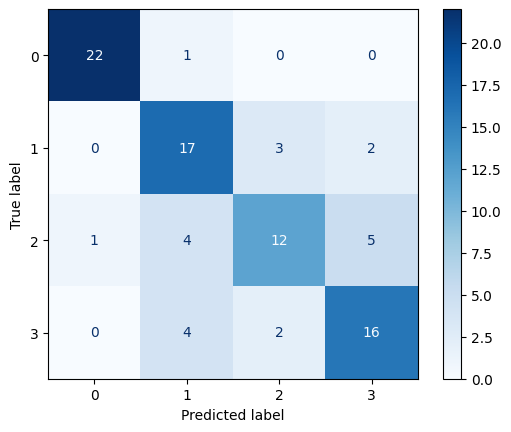

In [ ]:
# Testing the tuned multiclass classifier on testing data

testing(best_model,test_df,test_labels)

Accuracy:       0.7528089887640449
Precision:      0.7529756049577022
Recall:         0.7504940711462451
F1 Score:       0.7478376997398737
ROC-AUC Score:  0.9175810669970306



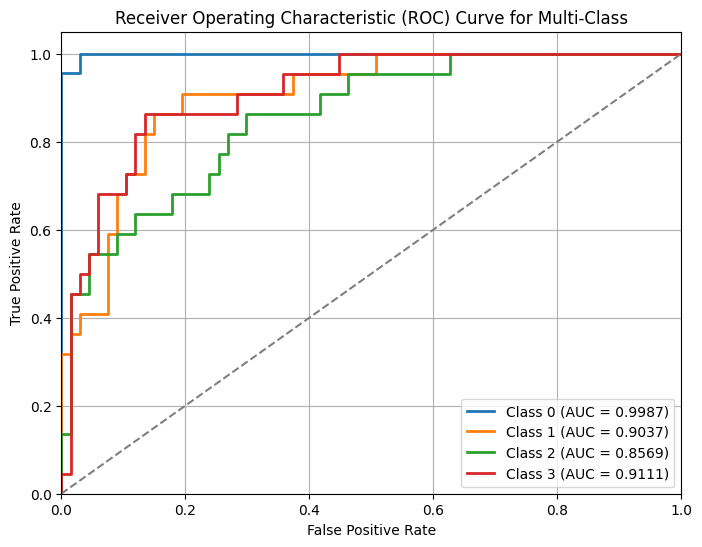

In [ ]:
# Evaluating the multiclass classifier performance using various metrics & plotting the ROC curve

accuracy,precision,recall,f1,roc_auc=multiclass_classifier_scores(best_model,test_df,test_labels)

print(f'Accuracy:       {accuracy}')
print(f'Precision:      {precision}')
print(f'Recall:         {recall}')
print(f'F1 Score:       {f1}')
print(f'ROC-AUC Score:  {roc_auc}\n')

plot_multiclass_roc_curve(best_model,test_df,test_labels)